In [1]:
INPUTS_DIR = "inputs"
RESULTS_DIR = "results"

In [2]:
import os
import random

def generate_input_file(number_of_threads, number_of_shapes,
                        min_x=0, max_x=30, min_y=0, max_y=30, min_size=0, max_size=5,
                        output_dir=INPUTS_DIR):
    os.makedirs(output_dir, exist_ok=True)
    
    delta_x = max_x - min_x
    delta_y = max_y - min_y
    
    # Create a descriptive filename based on parameters
    filename = f"grid_{delta_x}x{delta_y}_shapes_{number_of_shapes}_threads_{number_of_threads}.txt"
    path = os.path.join(output_dir, filename)
    
    with open(path, "w") as f:
        f.write(f"{delta_x}\n{delta_y}\n{number_of_shapes}\n{number_of_threads}\n")
        for _ in range(number_of_shapes):
            x = random.uniform(min_x, max_x)
            y = random.uniform(min_y, max_y)
            s = random.uniform(min_size, max_size)
            f.write(f"{s}\n{x}\n{y}\n")
    print(f"Generated: {path}")

shape_counts = [100, 500, 1000, 2000, 5000]
thread_counts = [1, 8, 16, 64]
grid_sizes = [(10, 10), (30, 30), (100, 100), (200, 200), (500, 500)]

for shapes in shape_counts:
    for threads in thread_counts:
        for max_x, max_y in grid_sizes:
            generate_input_file(
                number_of_threads=threads,
                number_of_shapes=shapes,
                max_x=max_x,
                max_y=max_y
            )


Generated: inputs/grid_10x10_shapes_100_threads_1.txt
Generated: inputs/grid_30x30_shapes_100_threads_1.txt
Generated: inputs/grid_100x100_shapes_100_threads_1.txt
Generated: inputs/grid_200x200_shapes_100_threads_1.txt
Generated: inputs/grid_500x500_shapes_100_threads_1.txt
Generated: inputs/grid_10x10_shapes_100_threads_8.txt
Generated: inputs/grid_30x30_shapes_100_threads_8.txt
Generated: inputs/grid_100x100_shapes_100_threads_8.txt
Generated: inputs/grid_200x200_shapes_100_threads_8.txt
Generated: inputs/grid_500x500_shapes_100_threads_8.txt
Generated: inputs/grid_10x10_shapes_100_threads_16.txt
Generated: inputs/grid_30x30_shapes_100_threads_16.txt
Generated: inputs/grid_100x100_shapes_100_threads_16.txt
Generated: inputs/grid_200x200_shapes_100_threads_16.txt
Generated: inputs/grid_500x500_shapes_100_threads_16.txt
Generated: inputs/grid_10x10_shapes_100_threads_64.txt
Generated: inputs/grid_30x30_shapes_100_threads_64.txt
Generated: inputs/grid_100x100_shapes_100_threads_64.txt


In [7]:
import subprocess
import re
import pandas as pd
import matplotlib.pyplot as plt
import os

# Ensure output directory exists
os.makedirs(RESULTS_DIR, exist_ok=True)

# List of input files
input_files = sorted([f for f in os.listdir(INPUTS_DIR) if f.endswith(".txt")])

# Data collection structure
results = {
    "file_name": [],
    "deltaX": [],
    "deltaY": [],
    "num_shapes": [],
    "num_threads": [],
    "Sequential (ms)": [],
    "Parallel (ms)": [],
}

for input_file in input_files:
    input_path = os.path.join(INPUTS_DIR, input_file)
    
    # Parse input file metadata
    with open(input_path, "r") as f:
        lines = f.readlines()
        if len(lines) < 4:
            continue  # skip invalid files
        deltaX = int(lines[0].strip())
        deltaY = int(lines[1].strip())
        num_shapes = int(lines[2].strip())
        num_threads = int(lines[3].strip())

    # Run benchmark
    cmd = ["bash", "benchmark.sh", "--input", input_path]
    try:
        output = subprocess.check_output(cmd, text=True)
        sequential_match = re.search(r"Average time for CircleSequential: (\d+) ns", output)
        parallel_match = re.search(r"Average time for CircleParallel: (\d+) ns", output)

        if sequential_match and parallel_match:
            sequential_time_ms = int(sequential_match.group(1)) / 1e6
            parallel_time_ms = int(parallel_match.group(1)) / 1e6

            results["file_name"].append(input_file)
            results["deltaX"].append(deltaX)
            results["deltaY"].append(deltaY)
            results["num_shapes"].append(num_shapes)
            results["num_threads"].append(num_threads)
            results["Sequential (ms)"].append(sequential_time_ms)
            results["Parallel (ms)"].append(parallel_time_ms)

    except subprocess.CalledProcessError as e:
        print(f"Benchmarking failed for {input_file}: {e}")

# Create DataFrame and save to CSV
df = pd.DataFrame(results)
csv_path = os.path.join(RESULTS_DIR, "benchmark_data.csv")
df.to_csv(csv_path, index=False)

# Plot and save the graph
plt.figure(figsize=(12, 6))
plt.plot(df["file_name"], df["Sequential (ms)"], label="Sequential (ms)", marker='o')
plt.plot(df["file_name"], df["Parallel (ms)"], label="Parallel (ms)", marker='x')
plt.xticks(rotation=45)
plt.xlabel("Input File")
plt.ylabel("Average Time (ms)")
plt.title("Benchmark Performance: Sequential vs Parallel")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "performance_plot.png"))
plt.close()

Benchmarking failed for grid_100x100_shapes_1000_threads_1.txt: Command '['bash', 'benchmark.sh', '--inut', 'inputs/grid_100x100_shapes_1000_threads_1.txt']' returned non-zero exit status 1.
Benchmarking failed for grid_100x100_shapes_1000_threads_16.txt: Command '['bash', 'benchmark.sh', '--inut', 'inputs/grid_100x100_shapes_1000_threads_16.txt']' returned non-zero exit status 1.
Benchmarking failed for grid_100x100_shapes_1000_threads_64.txt: Command '['bash', 'benchmark.sh', '--inut', 'inputs/grid_100x100_shapes_1000_threads_64.txt']' returned non-zero exit status 1.
Benchmarking failed for grid_100x100_shapes_1000_threads_8.txt: Command '['bash', 'benchmark.sh', '--inut', 'inputs/grid_100x100_shapes_1000_threads_8.txt']' returned non-zero exit status 1.
Benchmarking failed for grid_100x100_shapes_100_threads_1.txt: Command '['bash', 'benchmark.sh', '--inut', 'inputs/grid_100x100_shapes_100_threads_1.txt']' returned non-zero exit status 1.
Benchmarking failed for grid_100x100_shapes

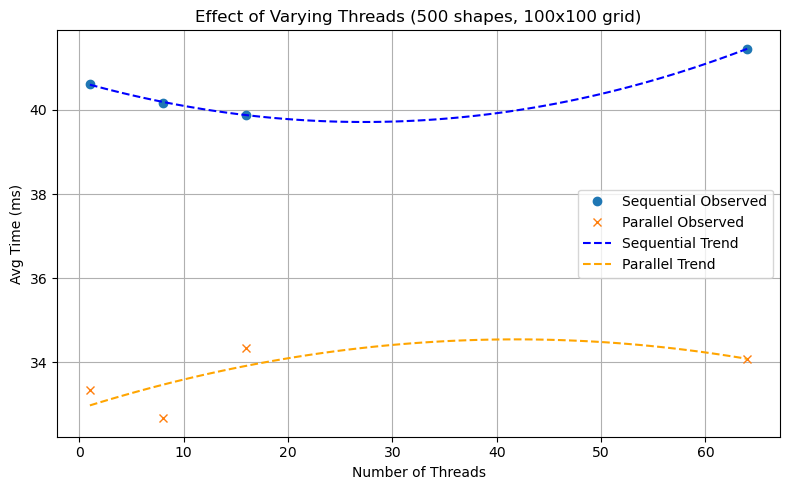

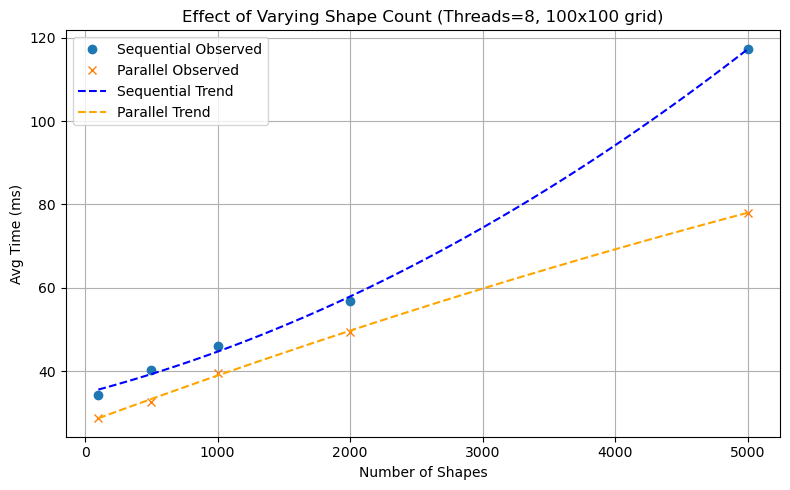

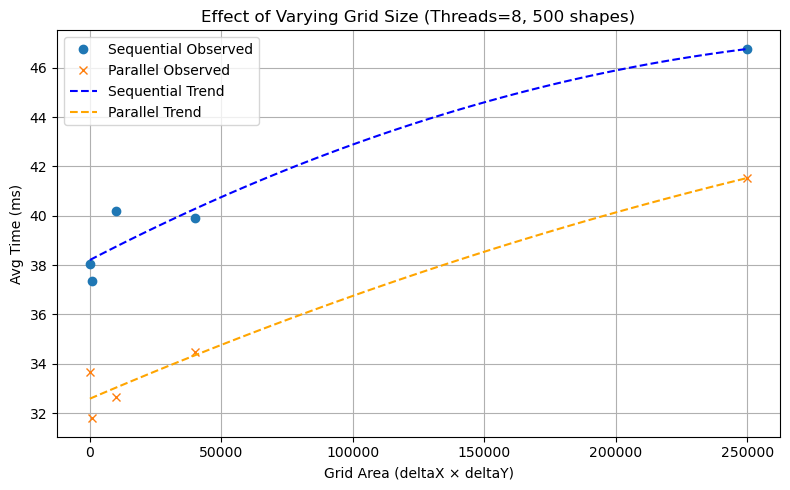

In [5]:
import numpy as np

def plot_with_trendlines(
    x,
    y1,
    y2,
    xlabel,
    ylabel,
    title,
    filename,
    label1="Sequential",
    label2="Parallel",
    marker1='o',
    marker2='x'
):
    plt.figure(figsize=(8, 5))

    # Observed points
    plt.plot(x, y1, marker=marker1, linestyle='', label=f"{label1} Observed")
    plt.plot(x, y2, marker=marker2, linestyle='', label=f"{label2} Observed")

    # Trend line for y1
    coeffs1 = np.polyfit(x, y1, 2 if len(x) > 3 else 1)
    poly1 = np.poly1d(coeffs1)
    x_fit = np.linspace(min(x), max(x), 100)
    plt.plot(x_fit, poly1(x_fit), linestyle='--', color='blue', label=f"{label1} Trend")

    # Trend line for y2
    coeffs2 = np.polyfit(x, y2, 2 if len(x) > 3 else 1)
    poly2 = np.poly1d(coeffs2)
    plt.plot(x_fit, poly2(x_fit), linestyle='--', color='orange', label=f"{label2} Trend")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()

# --- 1. Varying Threads ---
threads_df = df[(df["num_shapes"] == 500) & (df["deltaX"] == 100) & (df["deltaY"] == 100)]
plot_with_trendlines(
    x=threads_df["num_threads"],
    y1=threads_df["Sequential (ms)"],
    y2=threads_df["Parallel (ms)"],
    xlabel="Number of Threads",
    ylabel="Avg Time (ms)",
    title="Effect of Varying Threads (500 shapes, 100x100 grid)",
    filename="vary_threads.png"
)

# --- 2. Varying Shape Count ---
shapes_df = df[(df["num_threads"] == 8) & (df["deltaX"] == 100) & (df["deltaY"] == 100)]
plot_with_trendlines(
    x=shapes_df["num_shapes"],
    y1=shapes_df["Sequential (ms)"],
    y2=shapes_df["Parallel (ms)"],
    xlabel="Number of Shapes",
    ylabel="Avg Time (ms)",
    title="Effect of Varying Shape Count (Threads=8, 100x100 grid)",
    filename="vary_shapes.png"
)

# --- 3. Varying Grid Size ---
grid_df = df[(df["num_threads"] == 8) & (df["num_shapes"] == 500)].copy()
grid_df["Grid Size"] = grid_df["deltaX"] * grid_df["deltaY"]
plot_with_trendlines(
    x=grid_df["Grid Size"],
    y1=grid_df["Sequential (ms)"],
    y2=grid_df["Parallel (ms)"],
    xlabel="Grid Area (deltaX × deltaY)",
    ylabel="Avg Time (ms)",
    title="Effect of Varying Grid Size (Threads=8, 500 shapes)",
    filename="vary_grid_size.png"
)


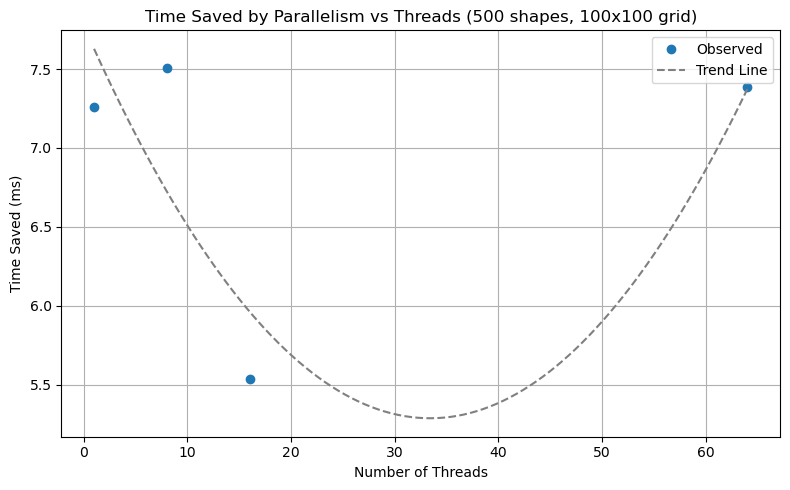

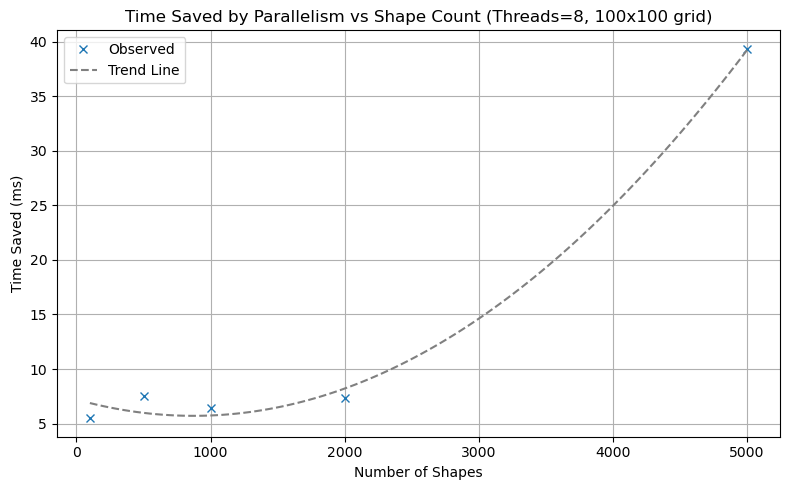

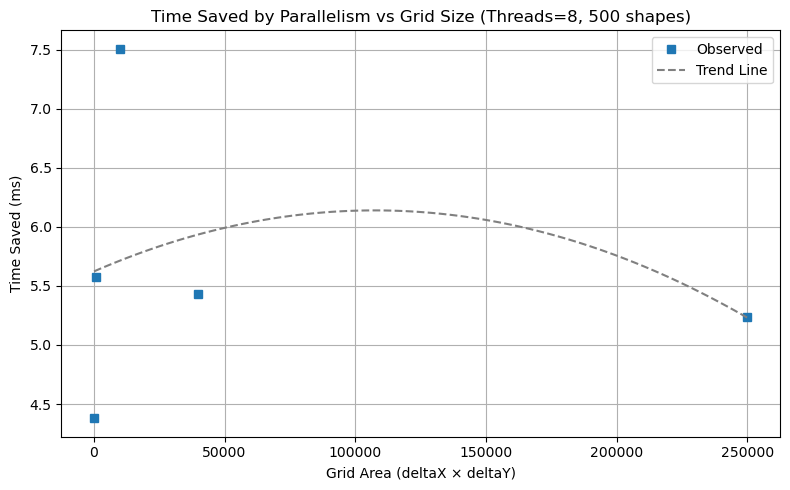

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load benchmark results
df = pd.read_csv(csv_path)

# Add time saved and % saved columns
df["Time Saved (ms)"] = df["Sequential (ms)"] - df["Parallel (ms)"]
df["% Time Saved"] = 100 * df["Time Saved (ms)"] / df["Sequential (ms)"]

def plot_with_trend(x, y, xlabel, ylabel, title, filename, marker='o'):
    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker=marker, linestyle='', label="Observed")
    
    # Fit and plot trend line
    coeffs = np.polyfit(x, y, 2 if len(x) > 3 else 1)  # Quadratic if enough points
    poly = np.poly1d(coeffs)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = poly(x_fit)
    plt.plot(x_fit, y_fit, label="Trend Line", color='gray', linestyle='--')
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, filename))
    plt.show()

# === 1. Threads ===
threads_df = df[(df["num_shapes"] == 500) & (df["deltaX"] == 100) & (df["deltaY"] == 100)]
plot_with_trend(
    threads_df["num_threads"],
    threads_df["Time Saved (ms)"],
    "Number of Threads",
    "Time Saved (ms)",
    "Time Saved by Parallelism vs Threads (500 shapes, 100x100 grid)",
    "time_saved_threads.png"
)

# === 2. Shape Count ===
shapes_df = df[(df["num_threads"] == 8) & (df["deltaX"] == 100) & (df["deltaY"] == 100)]
plot_with_trend(
    shapes_df["num_shapes"],
    shapes_df["Time Saved (ms)"],
    "Number of Shapes",
    "Time Saved (ms)",
    "Time Saved by Parallelism vs Shape Count (Threads=8, 100x100 grid)",
    "time_saved_shapes.png",
    marker='x'
)

# === 3. Grid Size ===
grid_df = df[(df["num_threads"] == 8) & (df["num_shapes"] == 500)].copy()
grid_df["Grid Size"] = grid_df["deltaX"] * grid_df["deltaY"]
plot_with_trend(
    grid_df["Grid Size"],
    grid_df["Time Saved (ms)"],
    "Grid Area (deltaX × deltaY)",
    "Time Saved (ms)",
    "Time Saved by Parallelism vs Grid Size (Threads=8, 500 shapes)",
    "time_saved_grid_size.png",
    marker='s'
)